In [3]:
import threading
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib.slim as slim
import scipy.signal
import scipy
%matplotlib inline
from helper import *
from vizdoom import *
from datetime import datetime as dt

from random import choice
from time import sleep
from time import time

import sys
sys.path.append('C:\\Users\\elind\\Documents\\GitHub\\02460_doom_rl_2019')
sys.path.append('C:\\Users\\elind\\Documents\\GitHub\\02460_doom_rl_2019\\baselines-master')

# The new things 
import gym

import cv2
from gdoom_env import *

# A global variable to save amoount of kills
kill_list= []


In [4]:
# Copies one set of variables to another.
# Used to set worker network parameters to those of global network.
def update_target_graph(from_scope,to_scope):
    from_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, from_scope)
    to_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, to_scope)

    op_holder = []
    for from_var,to_var in zip(from_vars,to_vars):
        op_holder.append(to_var.assign(from_var))
    return op_holder

# Processes Doom screen image to produce cropped and resized image. 
def process_frame(frame):
    sk=frame #s = frame[10:-10,30:-30] So no cropping of the image...
    top=int(round(0.10*sk.shape[1],0))
    down=int(round(0.8125*sk.shape[1],0))
    sk=sk[(top):(down),:]
    # Now:
    #sk = scipy.misc.imresize(sk,[64,64])

    # Before:
    #s=scipy.misc.imresize(s,[84,84]) # This function b idea
    
    # As the gym framework is outputting all the frame when it skips 4, so the observation is 4 frame
    
    sk = np.reshape(sk,[np.prod(sk.shape)]) / 255.0
    return sk
def get_last_frame(frame):
    sp=frame.shape
    #print(sp)
    return frame[:,:,sp[2]-1]

# Discounting function used to calculate discounted returns.
def discount(x, gamma):
    return scipy.signal.lfilter([1], [1, -gamma], x[::-1], axis=0)[::-1]

#Used to initialize weights for policy and value output layers
def normalized_columns_initializer(std=1.0):
    def _initializer(shape, dtype=None, partition_info=None):
        out = np.random.randn(*shape).astype(np.float32)
        out *= std / np.sqrt(np.square(out).sum(axis=0, keepdims=True))
        return tf.constant(out)
    return _initializer

In [5]:
class AC_Network():
    def __init__(self,s_size,a_size,scope,trainer):
        with tf.variable_scope(scope):
            #Input and visual encoding layers
            self.inputs = tf.placeholder(shape=[None,s_size],dtype=tf.float32)
            #self.imageIn = tf.reshape(self.inputs,shape=[-1,84,84,1])
            #self.imageIn = tf.reshape(self.inputs,shape=[-1,64,64,1]) # Changed the values to 64, dont know why (Properly because of the screenresolution).
            #68*96
            self.imageIn = tf.reshape(self.inputs,shape=[-1,68,96,1])
            self.conv1 = slim.conv2d(activation_fn=tf.nn.elu,
                inputs=self.imageIn,num_outputs=16,
                kernel_size=[8,8],stride=[4,4],padding='VALID')
            self.conv2 = slim.conv2d(activation_fn=tf.nn.elu,
                inputs=self.conv1,num_outputs=32,
                kernel_size=[4,4],stride=[2,2],padding='VALID')
            hidden = slim.fully_connected(slim.flatten(self.conv2),256,activation_fn=tf.nn.elu)
            
            #Recurrent network for temporal dependencies
            lstm_cell = tf.contrib.rnn.BasicLSTMCell(256,state_is_tuple=True)
            c_init = np.zeros((1, lstm_cell.state_size.c), np.float32)
            h_init = np.zeros((1, lstm_cell.state_size.h), np.float32)
            self.state_init = [c_init, h_init]
            c_in = tf.placeholder(tf.float32, [1, lstm_cell.state_size.c])
            h_in = tf.placeholder(tf.float32, [1, lstm_cell.state_size.h])
            self.state_in = (c_in, h_in)
            rnn_in = tf.expand_dims(hidden, [0])
            step_size = tf.shape(self.imageIn)[:1]
            state_in = tf.contrib.rnn.LSTMStateTuple(c_in, h_in)
            lstm_outputs, lstm_state = tf.nn.dynamic_rnn(
                lstm_cell, rnn_in, initial_state=state_in, sequence_length=step_size,
                time_major=False)
            lstm_c, lstm_h = lstm_state
            self.state_out = (lstm_c[:1, :], lstm_h[:1, :])
            rnn_out = tf.reshape(lstm_outputs, [-1, 256])
            
            #Output layers for policy and value estimations
            self.policy = slim.fully_connected(rnn_out,a_size,
                activation_fn=tf.nn.softmax,
                weights_initializer=normalized_columns_initializer(0.01),
                biases_initializer=None)
            self.value = slim.fully_connected(rnn_out,1,
                activation_fn=None,
                weights_initializer=normalized_columns_initializer(1.0),
                biases_initializer=None)
            
            #Only the worker network need ops for loss functions and gradient updating.
            if scope != 'global':
                self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
                self.actions_onehot = tf.one_hot(self.actions,a_size,dtype=tf.float32)
                self.target_v = tf.placeholder(shape=[None],dtype=tf.float32)
                self.advantages = tf.placeholder(shape=[None],dtype=tf.float32)

                self.responsible_outputs = tf.reduce_sum(self.policy * self.actions_onehot, [1])

                #Loss functions
                self.value_loss = 0.5 * tf.reduce_sum(tf.square(self.target_v - tf.reshape(self.value,[-1])))
                self.entropy = - tf.reduce_sum(self.policy * tf.log(self.policy))
                self.policy_loss = -tf.reduce_sum(tf.log(self.responsible_outputs)*self.advantages)
                self.loss = 0.5 * self.value_loss + self.policy_loss - self.entropy * 0.01

                #Get gradients from local network using local losses
                local_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope)
                self.gradients = tf.gradients(self.loss,local_vars)
                self.var_norms = tf.global_norm(local_vars)
                grads,self.grad_norms = tf.clip_by_global_norm(self.gradients,40.0)
                
                #Apply local gradients to global network
                global_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'global')
                self.apply_grads = trainer.apply_gradients(zip(grads,global_vars))

In [6]:
class Worker():
    # Defining input
    ## game is framework of the game
    ## name Of the worker worker_1, 2 3.
    ## s_size  So tensorflow values ?? But what kind?
    ## a_size So tensorflow values ?? But what kind?
    ## trainer 
    ## model_path  Is where the model should go in
    ## global_episodes  Number of global episodes
    def __init__(self,game,name,s_size,a_size,trainer,model_path,global_episodes,hyperparametersstring):
        # The name
        self.name = "worker_" + str(name)
        # The number is 0,1,2,3
        self.number = name        
        # Model path
        self.model_path = model_path
        # So this is the adamoptimizer
        self.trainer = trainer
        
        self.global_episodes = global_episodes
        # The increment of episode ## Could this be something else than 1? That would be weird.
        self.increment = self.global_episodes.assign_add(1)
        self.episode_rewards = []
        self.episode_kills = []
        self.episode_lengths = []
        self.episode_mean_values = []
                                                    # This is where 
        self.summary_writer = tf.summary.FileWriter("train_"+hyperparametersstring+str(self.number))

        #Create the local copy of the network and the tensorflow op to copy global paramters to local network
        self.local_AC = AC_Network(s_size,a_size,self.name,trainer)
        self.update_local_ops = update_target_graph('global',self.name)        
        
        #The Below code is related to setting up the Doom environment
#         game.set_doom_scenario_path("basic.wad") #This corresponds to the simple task we will pose our agent
#         game.set_doom_map("map01")
#         game.set_screen_resolution(ScreenResolution.RES_160X120)
#         game.set_screen_format(ScreenFormat.GRAY8)
#         game.set_render_hud(False)
#         game.set_render_crosshair(False)
#         game.set_render_weapon(True)
#         game.set_render_decals(False)
#         game.set_render_particles(False)
#         game.add_available_button(Button.MOVE_LEFT)
#         game.add_available_button(Button.MOVE_RIGHT)
#         game.add_available_button(Button.ATTACK)
#         game.add_available_game_variable(GameVariable.AMMO2)
#         game.add_available_game_variable(GameVariable.POSITION_X)
#         game.add_available_game_variable(GameVariable.POSITION_Y)
#         game.set_episode_timeout(300)
#         game.set_episode_start_time(10)
#         game.set_window_visible(False)
#         game.set_sound_enabled(False)
#         game.set_living_reward(-1)
#         game.set_mode(Mode.PLAYER)
#         game.init()
        self.actions = self.actions = np.identity(a_size,dtype=bool).tolist() 
        ## Think has to be converted into The gym environment....
        #End Doom set-up
        self.env = game
        
    def train(self,rollout,sess,gamma,bootstrap_value):
        rollout = np.array(rollout)
        observations = rollout[:,0]
        actions = rollout[:,1]
        rewards = rollout[:,2]
        next_observations = rollout[:,3]
        values = rollout[:,5]
        
        # Here we take the rewards and values from the rollout, and use them to 
        # generate the advantage and discounted returns. 
        # The advantage function uses "Generalized Advantage Estimation"
        self.rewards_plus = np.asarray(rewards.tolist() + [bootstrap_value])
        discounted_rewards = discount(self.rewards_plus,gamma)[:-1]
        self.value_plus = np.asarray(values.tolist() + [bootstrap_value])
        advantages = rewards + gamma * self.value_plus[1:] - self.value_plus[:-1]
        advantages = discount(advantages,gamma)

        # Update the global network using gradients from loss
        # Generate network statistics to periodically save
        feed_dict = {self.local_AC.target_v:discounted_rewards,
            self.local_AC.inputs:np.vstack(observations),
            self.local_AC.actions:actions,
            self.local_AC.advantages:advantages,
            self.local_AC.state_in[0]:self.batch_rnn_state[0],
            self.local_AC.state_in[1]:self.batch_rnn_state[1]}
        v_l,p_l,e_l,g_n,v_n, self.batch_rnn_state,_ = sess.run([self.local_AC.value_loss,
            self.local_AC.policy_loss,
            self.local_AC.entropy,
            self.local_AC.grad_norms,
            self.local_AC.var_norms,
            self.local_AC.state_out,
            self.local_AC.apply_grads],
            feed_dict=feed_dict)
        return v_l / len(rollout),p_l / len(rollout),e_l / len(rollout), g_n,v_n
        
    def work(self,max_episode_length,gamma,sess,coord,saver,batchsize,Numberofepisodesbeforebreak,hyperparametersstring):
        episode_count = sess.run(self.global_episodes)
        total_steps = 0
        print ("Starting worker " + str(self.number))
        with sess.as_default(), sess.graph.as_default():                 
            while not coord.should_stop():
                sess.run(self.update_local_ops)
                episode_buffer = []
                episode_values = []
                episode_frames = []
                episode_kill = 0
                episode_reward = 0
                episode_step_count = 0
                d = False
                
                # Old: s = self.env.get_state().screen_buffer
                
                s=np.asarray(self.env.reset()) #Changed from self.env.new_episode()
                #s = self.env.get_state().screen_buffer
                
                
                 # Old: episode_frames.append(s)
                #print('s shape',s.shape)
                #print('before',s.shape)
                
                #print('after',s.shape)
                #print('s shape',s.shape)
                for k in range(0,s.shape[2]):
                    episode_frames.append(s[:,:,k])
                    
                s=get_last_frame(s)
                
               
                s = process_frame(s) # This function cropped (not anymore) and raveled the image into 1 dimensional vector  
                
                rnn_state = self.local_AC.state_init
                self.batch_rnn_state = rnn_state
                while d==False:   # Before self.env.is_episode_finished() == False:
                    #Take an action using probabilities from policy network output.
                    a_dist,v,rnn_state = sess.run([self.local_AC.policy,self.local_AC.value,self.local_AC.state_out], 
                        feed_dict={self.local_AC.inputs:[s],
                        self.local_AC.state_in[0]:rnn_state[0],
                        self.local_AC.state_in[1]:rnn_state[1]})
                    a = np.random.choice(a_dist[0],p=a_dist[0])
                    a = np.argmax(a_dist == a)
                    
                    #ob, reward, done, info
                    #print('a=',a)
                    #print('a type',type(a))
                    #print(self.actions[a])
                    
                    state,r,d,misc=self.env.step(int(a)) # So gym output the state, reward, isdone, misc is kills
                    #state # 4 frames
                    #r # Reward
                    #d # Is done if True the episode is done
                    #misc # If the program done...

                    # And time per episode.
                    #r = self.env.make_action(self.actions[a]) / 100.0
                    # Maybe the 100 divided is important!
                    
                    #r=r/100 This was uncommented!
                    
                    #d = self.env.is_episode_finished()
                    if d == False:
                        s1 = np.asarray(state) #self.env.get_state().screen_buffer
                        #episode_frames.append(s1)
                        #print('s1',s1.shape)
                        
                        
                        episode_frames.append(get_last_frame(s1))
                        s1 = process_frame(get_last_frame(s1))
                        #print(s1.shape)
                    else:
                        s1 = s
                        
                    episode_buffer.append([s,a,r,s1,d,v[0,0]])
                    episode_values.append(v[0,0])
                    
                    
                    episode_reward += r
                    s = s1                    
                    total_steps += 1
                    episode_step_count += 1
                    
                    # If the episode hasn't ended, but the experience buffer is full, then we
                    # make an update step using that experience rollout.
                    # So this len(episode_buffer) == 20 is the batch size.
                    if len(episode_buffer) == batchsize and d != True and episode_step_count != max_episode_length - 1:
                        # Since we don't know what the true final return is, we "bootstrap" from our current
                        # value estimation.
                        v1 = sess.run(self.local_AC.value, 
                            feed_dict={self.local_AC.inputs:[s],
                            self.local_AC.state_in[0]:rnn_state[0],
                            self.local_AC.state_in[1]:rnn_state[1]})[0,0]
                        v_l,p_l,e_l,g_n,v_n = self.train(episode_buffer,sess,gamma,v1)
                        episode_buffer = []
                        sess.run(self.update_local_ops)
                    if d == True:
                        break
                        
                episode_kill = misc['kills']
                self.episode_kills.append(episode_kill)
                self.episode_rewards.append(episode_reward)
                self.episode_lengths.append(episode_step_count)
                self.episode_mean_values.append(np.mean(episode_values))
                
                # Update the network using the episode buffer at the end of the episode.
                if len(episode_buffer) != 0:
                    v_l,p_l,e_l,g_n,v_n = self.train(episode_buffer,sess,gamma,0.0)
                    
                print('Kills for last episode',misc['kills'])
                kill_list.append(misc['kills'])
                #Average over every 5 episodes and save avg_kills[i]
                                
                    
                # Periodically save gifs of episodes, model parameters, and summary statistics.
                if episode_count % 5 == 0 and episode_count != 0:
                    if self.name == 'worker_0' and episode_count % 25 == 0:
                        time_per_step = 0.05*2 # The 4 is because we had 4 timeskips, now 
                        images = np.array(episode_frames)
                        make_gif(images,'./frames'+str(hyperparametersstring)+'/image'+str(episode_count)+'.gif',
                            duration=len(images)*time_per_step,true_image=True,salience=False)
                    if episode_count % 250 == 0 and self.name == 'worker_0':
                        saver.save(sess,self.model_path+'/model-'+str(episode_count)+'.cptk')
                        print ("Saved Model")

                    mean_reward = np.mean(self.episode_rewards[-5:])
                    mean_length = np.mean(self.episode_lengths[-5:])
                    mean_value = np.mean(self.episode_mean_values[-5:])
                    mean_kill = np.mean(self.episode_kills[-5:])
                    summary = tf.Summary()
                    summary.value.add(tag='Perf/Reward', simple_value=float(mean_reward))
                    summary.value.add(tag='Perf/Length', simple_value=float(mean_length))
                    summary.value.add(tag='Perf/Value', simple_value=float(mean_value))
                    summary.value.add(tag='Perf/Kills', simple_value=float(mean_kill))
                    summary.value.add(tag='Losses/Value Loss', simple_value=float(v_l))
                    summary.value.add(tag='Losses/Policy Loss', simple_value=float(p_l))
                    summary.value.add(tag='Losses/Entropy', simple_value=float(e_l))
                    summary.value.add(tag='Losses/Grad Norm', simple_value=float(g_n))
                    summary.value.add(tag='Losses/Var Norm', simple_value=float(v_n))
                    self.summary_writer.add_summary(summary, episode_count)

                    self.summary_writer.flush()
                if self.name == 'worker_0':
                    sess.run(self.increment)
                if Numberofepisodesbeforebreak == episode_count:
                    break
                episode_count += 1

In [7]:

k=[10,50,100]
lrs=[1e-3,1e-4]
Numberofepisodesbeforebreak=10000
for j in range(0,1):
    # Number of learning
    for i in range(0,3):
        print(i)
        #%# So there is some parameters for the the neural network. 
        # The max episode length and gamma is used in the worker.work class.
        max_episode_length = 300*2*3/2
        gamma = .99 # discount rate for advantage estimation and reward discounting

        #%# These are for the neural network
        s_size = 68*96#64*64#7056 # Observations are greyscale frames of 84 * 84 * 1
        a_size = 3 # Agent can move Left, Right, or Fire
        load_model = False
        model_path = './model'
        # The learing rate for the run
        lr=lrs[j]
        # What we call the model train
        batchsize=k[i]
        hyperparametersstring='v2s2_lr='+str(lr)+'_'+'bs='+str(batchsize) + '_' + str(dt.now().date()) + str(dt.now().hour)
        model_path = './model'+hyperparametersstring



        # The tensor flow graph.
        tf.reset_default_graph()

        # Makes a directory for the model. if it didn't exist.
        if not os.path.exists(model_path):
            os.makedirs(model_path)

        #Create a directory to save episode playback gifs to
        if not os.path.exists('./frames'+str(hyperparametersstring)):
            os.makedirs('./frames'+str(hyperparametersstring))

        #%# So the with statement, is like a try catch thing, where is does something with a thing,and then ?closes? the 
        # Environment after.
        # tf.device is Wrapper for Graph.device() using the default graph.
        # A wrapper has something to do with being a class on a object  as a class object.
        # So here we are setting up the workers for the code.
        with tf.device("/cpu:0"): 
            # So this is a tensorflow variable, global_episode=0. So here the global episode is =0.
            global_episodes = tf.Variable(0,dtype=tf.int32,name='global_episodes',trainable=False)
            # The optimizer for the nueral network I guess... With a learning rate of 0.001
            trainer = tf.train.RMSPropOptimizer(learning_rate=lr, decay = 0.99)# Was 1e-4
            # So here we are calling the AC_Network. A global network.
            master_network = AC_Network(s_size,a_size,'global',None) # Generate global network
            num_workers = multiprocessing.cpu_count() # Set workers to number of available CPU threads
            workers = []
            # Create worker classes
            # For every worker we make a different doomgame. And set it up
            for i in range(num_workers):
                # Are using the vizdoom standard way of setting it up.
                workers.append(Worker(gym.make("doom_scenario2_96-v0"),i,s_size,a_size,trainer,model_path,global_episodes,hyperparametersstring))
            saver = tf.train.Saver(max_to_keep=5)

        # So these two thing are the same
        # 1
        ## Using the `close()` method.
        #sess = tf.Session()
        #sess.run(...)
        #sess.close()
        # 2 
        ## Using the context manager.
        #with tf.Session() as sess:
        #  sess.run(...)

        # tf.session is where the network, is running. Or it is a session in tensorflow where as 
        with tf.Session() as sess:
            # So the coordinator is a function/class/object, which are handeling the coordiation between the threads.
            # And I guess we for thread for each worker.
            coord = tf.train.Coordinator()
            # so there is a argument for load_model in the input to the code.
            # So if is loading i guess it will start from there it stopped previously.
            if load_model == True:
                print ('Loading Model...')
                ckpt = tf.train.get_checkpoint_state(model_path)
                saver.restore(sess,ckpt.model_checkpoint_path)
            else:
                # If not true, it will start randomly.
                # tf.global_variables_initializer
                #tf.initializers.global_variables
                # So I guess 
                sess.run(tf.global_variables_initializer())

            # This is where the asynchronous magic happens.
            # Start the "work" process for each worker in a separate threat # Lols.
            worker_threads = []
            # So for every worker we do the multithreading workflow.
            for worker in workers:
                # Defining the work of the worker
                worker_work = lambda: worker.work(max_episode_length,gamma,sess,coord,saver,batchsize,Numberofepisodesbeforebreak,hyperparametersstring)
                t = threading.Thread(target=(worker_work))
                t.start()
                sleep(0.5)
                worker_threads.append(t)
            # Coordinating the work between the workers. # So is this the "magic"?
            coord.join(worker_threads)

0
Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').


C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\gym\logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Doom> Loading level: C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\vizdoom/scenarios/defend_the_center.cfg
Doom> Loading level: C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\vizdoom/scenarios/defend_the_center.cfg
Doom> Loading level: C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\vizdoom/scenarios/defend_the_center.cfg
Doom> Loading level: C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\vizdoom/scenarios/defend_the_center.cfg
Starting worker 0
Starting worker 1
Starting worker 2
Starting worker 3
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for las

Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
K

Kills for last episode 7.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 6.0
K

Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 2.0
K

Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
K

t:   0%|                                                                              | 0/73 [00:00<?, ?it/s, now=None]

Kills for last episode 5.0


Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 8.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
K

Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
K

t:  43%|█████████████████████████████                                       | 41/96 [00:00<00:00, 201.41it/s, now=None]

Kills for last episode 6.0


Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
K

Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 3.0
K

Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 1.0
K

t:  30%|████████████████████▋                                               | 28/92 [00:00<00:00, 142.51it/s, now=None]

Kills for last episode 7.0


Kills for last episode 3.0
Kills for last episode 2.0
Saved Model
Kills for last episode 8.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last e

t:  68%|██████████████████████████████████████████████▍                     | 43/63 [00:00<00:00, 214.34it/s, now=None]

Kills for last episode 2.0


Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
K

Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
K

Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
K

Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
K

Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
K

t:  26%|█████████████████▍                                                  | 21/82 [00:00<00:00, 204.43it/s, now=None]

Kills for last episode 3.0


t:  37%|████████████████████████▉                                           | 30/82 [00:00<00:00, 145.66it/s, now=None]

Kills for last episode 2.0


Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 9.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 5.0
K

Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
K

Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
K

t:  48%|████████████████████████████████▊                                   | 41/85 [00:00<00:00, 197.95it/s, now=None]

Kills for last episode 4.0


t:  62%|██████████████████████████████████████████▍                         | 53/85 [00:00<00:00, 157.39it/s, now=None]

Kills for last episode 0.0


Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 0.0
K

Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Saved Model
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last e

Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 3.0
K

Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 1.0
Kills for last episode 5.0
K

t:  62%|█████████████████████████████████████████▉                          | 45/73 [00:00<00:00, 205.93it/s, now=None]

Kills for last episode 7.0


Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
K

Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 1.0
K

Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 8.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 2.0
K

t:  20%|█████████████▍                                                     | 20/100 [00:00<00:00, 192.82it/s, now=None]

Kills for last episode 1.0


Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 5.0
K

Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 2.0
K

Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 2.0
K

Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
K

Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Saved Model
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last e

t:  48%|████████████████████████████████▍                                   | 42/88 [00:00<00:00, 173.44it/s, now=None]

Kills for last episode 4.0

t:  60%|████████████████████████████████████████▉                           | 53/88 [00:00<00:00, 143.40it/s, now=None]

Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
K

Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 8.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
K

t:  41%|███████████████████████████▉                                        | 37/90 [00:00<00:00, 188.25it/s, now=None]

Kills for last episode 2.0


Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
K

Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
K

t:  45%|█████████████████████████████▉                                     | 67/150 [00:00<00:00, 220.03it/s, now=None]

Kills for last episode 1.0


Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 8.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 7.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
K

Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
K

Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
K

Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 3.0
K

Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
K

t:  55%|█████████████████████████████████████▌                              | 53/96 [00:00<00:00, 160.72it/s, now=None]

Kills for last episode 5.0


Saved Model
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last e

Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 3.0
K

Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
K

Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
K

Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
K

t:  34%|██████████████████████▉                                             | 24/71 [00:00<00:00, 229.18it/s, now=None]

Kills for last episode 4.0


Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
K

Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 9.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
K

Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 5.0
K

Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 5.0
K

t:  48%|████████████████████████████████▊                                   | 43/89 [00:00<00:00, 164.42it/s, now=None]

Kills for last episode 4.0


t:  80%|██████████████████████████████████████████████████████▏             | 71/89 [00:00<00:00, 125.73it/s, now=None]

Kills for last episode 3.0


Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 2.0
K

Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 6.0
Saved Model
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last e

Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
K

t:  51%|██████████████████████████████████▍                                 | 41/81 [00:00<00:00, 178.30it/s, now=None]

Kills for last episode 3.0


Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
K

t:  94%|███████████████████████████████████████████████████████████████    | 95/101 [00:00<00:00, 174.50it/s, now=None]

Kills for last episode 1.0


Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
K

Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 5.0
K

Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 8.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
K

Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 7.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
K

Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 8.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 5.0
K

t:  60%|████████████████████████████████████████▍                           | 53/89 [00:00<00:00, 172.84it/s, now=None]

Kills for last episode 4.0


t:  76%|███████████████████████████████████████████████████▉                | 68/89 [00:00<00:00, 163.28it/s, now=None]

Kills for last episode 2.0

t:  97%|█████████████████████████████████████████████████████████████████▋  | 86/89 [00:00<00:00, 167.62it/s, now=None]

Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
K

Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
K

Kills for last episode 2.0
Kills for last episode 5.0
Saved Model
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last e

t:  77%|███████████████████████████████████████████████████▉               | 79/102 [00:00<00:00, 186.75it/s, now=None]

Kills for last episode 4.0


Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
K

Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
K

Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 9.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 2.0
K

Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
K

t:  86%|██████████████████████████████████████████████████████████▍         | 67/78 [00:00<00:00, 147.96it/s, now=None]

Kills for last episode 3.0


Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
K

t:  26%|█████████████████▌                                                  | 25/97 [00:00<00:00, 243.37it/s, now=None]

Kills for last episode 4.0


Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 1.0
K

Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
K

Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 3.0
K

Kills for last episode 4.0
Kills for last episode 8.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 8.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
K

t:  11%|███████▌                                                           | 17/150 [00:00<00:00, 163.90it/s, now=None]

Kills for last episode 3.0


Kills for last episode 3.0
Kills for last episode 0.0
Saved Model
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last e

t:  34%|██████████████████████▉                                             | 24/71 [00:00<00:00, 190.21it/s, now=None]

Kills for last episode 4.0


Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
K

Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0Kills for last episode 
1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
K

Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
K

Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
K

Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 8.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 8.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 8.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
K

Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 7.0Kills for last episode
 5.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 7.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 8.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 1.0
K

t:   0%|                                                                              | 0/89 [00:00<?, ?it/s, now=None]

Kills for last episode 4.0


t:  22%|███████████████▎                                                    | 20/89 [00:00<00:00, 102.58it/s, now=None]

Kills for last episode 2.0


Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 1.0
K

Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 5.0
K

Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 8.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 2.0
K

Kills for last episode 1.0
Kills for last episode 4.0
Saved Model
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 8.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last e

Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 2.0
K

Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 9.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 8.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
K

t:  83%|████████████████████████████████████████████████████████▍           | 73/88 [00:00<00:00, 179.38it/s, now=None]

Kills for last episode 6.0


Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 1.0
K

Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
K

Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 0.0
K

t:   0%|                                                                              | 0/58 [00:00<?, ?it/s, now=None]

Kills for last episode 1.0


Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
K

Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
K

Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
K

Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 2.0
K

t:  44%|██████████████████████████████                                      | 38/86 [00:00<00:00, 192.42it/s, now=None]

Kills for last episode 2.0


Kills for last episode 4.0
Kills for last episode 4.0
Saved Model
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last e

Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
K

t:  23%|███████████████▊                                                    | 13/56 [00:00<00:00, 127.14it/s, now=None]

Kills for last episode 3.0


Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 3.0
K

Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
K

Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
K

Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
K

Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 8.0
Kills for last episode 2.0
K

t:  43%|█████████████████████████████▏                                      | 24/56 [00:00<00:00, 179.58it/s, now=None]

Kills for last episode 2.0


t:  84%|█████████████████████████████████████████████████████████           | 47/56 [00:00<00:00, 120.78it/s, now=None]

Kills for last episode 3.0


Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 2.0
K

t:  33%|██████████████████████▎                                             | 24/73 [00:00<00:00, 233.64it/s, now=None]

Kills for last episode 1.0


Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 1.0
K

Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 1.0
K

Saved Model
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 8.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last e

Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
K

Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 7.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
K

Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 2.0
K

t:   0%|                                                                              | 0/88 [00:00<?, ?it/s, now=None]

Kills for last episode 3.0


Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
K

t:  28%|███████████████████                                                 | 19/68 [00:00<00:00, 188.62it/s, now=None]

Kills for last episode 3.0


Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 5.0
K

Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 6.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 6.0
K

t:  75%|███████████████████████████████████████████████████▏                | 58/77 [00:00<00:00, 196.22it/s, now=None]

Kills for last episode 2.0


Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
K

Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 1.0
K

Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
K

t:  46%|███████████████████████████████▌                                    | 45/97 [00:00<00:00, 219.19it/s, now=None]

Kills for last episode 5.0


Saved Model
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last e

Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
K

t:  42%|████████████████████████████▎                                       | 37/89 [00:00<00:00, 170.86it/s, now=None]

Kills for last episode 4.0


t:  90%|█████████████████████████████████████████████████████████████       | 80/89 [00:00<00:00, 132.51it/s, now=None]

Kills for last episode 5.0


Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 7.0
Kills for last episode 3.0
K

Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 8.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 6.0
K

Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
K

t:  66%|████████████████████████████████████████████▉                       | 37/56 [00:00<00:00, 190.02it/s, now=None]

Kills for last episode 7.0


Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
K

Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
K

t:  32%|█████████████████████▋                                              | 22/69 [00:00<00:00, 212.11it/s, now=None]

Kills for last episode 3.0


Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 4.0
K

t:  93%|██████████████████████████████████████████████████████████████▉     | 75/81 [00:00<00:00, 163.56it/s, now=None]

Kills for last episode 5.0


Kills for last episode 

4.0
Kills for last episode 6.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 0.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 4

Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 8.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
K

Kills for last episode 3.0
Kills for last episode 4.0
Saved Model
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last e

t:  48%|████████████████████████████████▎                                   | 38/80 [00:00<00:00, 191.78it/s, now=None]

Kills for last episode 7.0


Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 2.0
K

Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
K

Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
K

Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
K

t:  68%|█████████████████████████████████████████████▎                     | 90/133 [00:00<00:00, 161.94it/s, now=None]

Kills for last episode 4.0


t:  80%|█████████████████████████████████████████████████████             | 107/133 [00:00<00:00, 163.46it/s, now=None]

Kills for last episode 4.0


Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 1.0
K

t:  35%|███████████████████████▋                                            | 24/69 [00:00<00:00, 231.39it/s, now=None]

Kills for last episode 2.0


Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
K

Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 7.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 9.0
Kills for last episode 3.0
K

t:  60%|███████████████████████████████████████▊                           | 72/121 [00:00<00:00, 168.08it/s, now=None]

Kills for last episode 4.0


t:  82%|███████████████████████████████████████████████████████▋            | 99/121 [00:00<00:00, 99.45it/s, now=None]

Kills for last episode 2.0


Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 1.0
K

Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 9.0
K

Kills for last episode 1.0
Saved Model
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 10.0
Kills for last episode 2.0
Kills for last 

Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
K

Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
K

t:  34%|██████████████████████▊                                            | 35/103 [00:00<00:00, 175.13it/s, now=None]

Kills for last episode 3.0


Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
K

Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 1.0
K

t:   0%|                                                                              | 0/96 [00:00<?, ?it/s, now=None]

Kills for last episode 5.0


t:   9%|██████▌                                                               | 9/96 [00:00<00:01, 86.77it/s, now=None]

Kills for last episode 4.0


Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 8.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 6.0
K

Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 4.0
K

Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 8.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 1.0
K

t:  32%|██████████████████████                                              | 22/68 [00:00<00:00, 216.27it/s, now=None]

Kills for last episode 4.0


Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 7.0
K

t:  41%|███████████████████████████▉                                        | 23/56 [00:00<00:00, 228.33it/s, now=None]

Kills for last episode 1.0


Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 4.0
K

t:  88%|███████████████████████████████████████████████████████████▌        | 77/88 [00:00<00:00, 182.35it/s, now=None]

Kills for last episode 2.0


Saved Model
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode Kills for last episode2.0 
3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 7.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last e

Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
K

t:  33%|██████████████████████▋                                             | 19/57 [00:00<00:00, 188.62it/s, now=None]

Kills for last episode 4.0


t:  58%|███████████████████████████████████████▎                            | 33/57 [00:00<00:00, 168.53it/s, now=None]

Kills for last episode 2.0


Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 1.0
Kills for last episode 8.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 4.0
K

Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
K

t:  41%|████████████████████████████▏                                       | 24/58 [00:00<00:00, 229.18it/s, now=None]

Kills for last episode 2.0


Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
K

Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode Kills for last episode1.0 
0.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
K

Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
K

Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
K

Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
K

t:  25%|█████████████████                                                   | 17/68 [00:00<00:00, 148.87it/s, now=None]

Kills for last episode 3.0


Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
K

Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 7.0Saved Model

Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last e

Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
K

Kills for last episode 4.0
Kills for last episode 8.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 0.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
K

Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 1.0
K

Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
K

t:   0%|                                                                              | 0/56 [00:00<?, ?it/s, now=None]

Kills for last episode 3.0


t:  84%|█████████████████████████████████████████████████████████           | 47/56 [00:00<00:00, 150.79it/s, now=None]

Kills for last episode 4.0


Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
K

t:   0%|                                                                              | 0/51 [00:00<?, ?it/s, now=None]

Kills for last episode 3.0


Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
K

Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 8.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
K

Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 8.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
K

Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
K

Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 0.0
Saved Model
Kills for last episodeKills for last episode  4.02.0

Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last e

Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 4.0
K

t:  42%|████████████████████████████▍                                       | 23/55 [00:00<00:00, 228.33it/s, now=None]

Kills for last episode 5.0


Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 8.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
K

Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 0.0
K

t:  65%|████████████████████████████████████████████▎                       | 58/89 [00:00<00:00, 191.76it/s, now=None]

Kills for last episode 2.0


Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode Kills for last episode4.0 
2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 9.0
Kills for last episode 2.0
K

Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
K

Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 8.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
K

Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
K

t:   0%|                                                                              | 0/90 [00:00<?, ?it/s, now=None]

Kills for last episode 4.0


Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
K

Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
K

Kills for last episode 5.0
Kills for last episode 4.0
Saved Model
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 8.0
Kills for last episode 1.0
Kills for last episode 1.0Kills for last episode
 6.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last e

Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
K

t:   0%|                                                                              | 0/75 [00:00<?, ?it/s, now=None]

Kills for last episode 2.0


Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
K

Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
K

Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 8.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
K

Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
K

t:  71%|████████████████████████████████████████████████▎                   | 64/90 [00:00<00:00, 197.15it/s, now=None]

Kills for last episode 4.0


Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 0.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 0.0
K

Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 8.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
K

t:  42%|████████████████████████████▎                                       | 37/89 [00:00<00:00, 177.74it/s, now=None]

Kills for last episode 2.0


t:  83%|████████████████████████████████████████████████████████▌           | 74/89 [00:00<00:00, 179.58it/s, now=None]

Kills for last episode 2.0


Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 0.0
K

Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 1.0
K

t:  88%|██████████████████████████████████████████████████████████        | 110/125 [00:00<00:00, 169.40it/s, now=None]

Kills for last episode 3.0


Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Saved Model
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 8.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last e

Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 1.0
K

Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
K

Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
K

t:   0%|                                                                              | 0/68 [00:00<?, ?it/s, now=None]

Kills for last episode 1.0


Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
K

Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
K

t:  54%|████████████████████████████████████▍                               | 37/69 [00:00<00:00, 159.26it/s, now=None]

Kills for last episode 4.0


Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
K

t:  37%|█████████████████████████▎                                          | 32/86 [00:00<00:00, 160.66it/s, now=None]

Kills for last episode 3.0


Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
K

Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episodeKills for last episode  6.02.0

Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
K

Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 8.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
K

Kills for last episode 3.0
Saved Model
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 9.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last e

Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
K

Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 6.0
K

t:   0%|                                                                             | 0/109 [00:00<?, ?it/s, now=None]

Kills for last episode 2.0


Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
K

Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 7.0
Kills for last episode 2.0
K

t:  60%|████████████████████████████████████████▊                           | 54/90 [00:00<00:00, 162.29it/s, now=None]

Kills for last episode 3.0


Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 7.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
K

t:  53%|███████████████████████████████████▊                               | 54/101 [00:00<00:00, 159.44it/s, now=None]

Kills for last episode 3.0


Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
K

t:   0%|                                                                              | 0/87 [00:00<?, ?it/s, now=None]

Kills for last episode 5.0


Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 7.0
K

Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 8.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
K

Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 1.0
K

t:  60%|████████████████████████████████████████▊                           | 57/95 [00:00<00:00, 183.16it/s, now=None]

Kills for last episode 3.0


Kills for last episode 0.0
Saved Model
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last e

Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 0.0
K

Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 6.0
K

Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 0.0
K

Kills for last episode 2.0
Kills for last episode 5.0Kills for last episode
 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
K

t:  26%|█████████████████▌                                                  | 24/93 [00:00<00:00, 222.82it/s, now=None]

Kills for last episode 5.0


Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episodeKills for last episode  1.04.0

Kills for last episode 1.0
Kills for last episode 1.0
K

Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
K

Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 5.0
K

Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 1.0
K

t:   0%|                                                                              | 0/58 [00:00<?, ?it/s, now=None]

Kills for last episode 2.0
Kills for last episode 1.0


Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
K

Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Saved Model
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 8.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last e

t:  55%|█████████████████████████████████████▏                              | 41/75 [00:00<00:00, 196.78it/s, now=None]

Kills for last episode 5.0


t:  75%|██████████████████████████████████████████████████▊                 | 56/75 [00:00<00:00, 178.84it/s, now=None]

Kills for last episode 6.0


Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 5.0
K

Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
K

Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 8.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
K

Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 0.0
K

Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 1.0
K

Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 8.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 4.0
K

Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 3.0
K

t:  26%|█████████████████▋                                                  | 25/96 [00:00<00:00, 241.03it/s, now=None]

Kills for last episode 5.0


Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 2.0
K

t:  70%|███████████████████████████████████████████████▎                    | 48/69 [00:00<00:00, 152.96it/s, now=None]

Kills for last episode 1.0


Kills for last episode 3.0
Kills for last episode 8.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 7.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
K

t:   0%|                                                                             | 0/109 [00:00<?, ?it/s, now=None]

Kills for last episode 4.0


t:  44%|█████████████████████████████▌                                     | 48/109 [00:00<00:00, 122.40it/s, now=None]

Kills for last episode 3.0


Kills for last episode 4.0
Saved Model
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last e

Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
K

Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 3.0
K

Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 8.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
K

t:  66%|████████████████████████████████████████████▉                       | 37/56 [00:00<00:00, 181.96it/s, now=None]

Kills for last episode 5.0


Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
K

Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
K

Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
K

t:   0%|                                                                              | 0/67 [00:00<?, ?it/s, now=None]

Kills for last episode 2.0


Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 3.0
K

Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 6.0
K

Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 8.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 6.0
K

Kills for last episode 2.0
Kills for last episode 4.0
Saved Model
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last e

Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 1.0
K

Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 8.0
Kills for last episode 2.0
K

Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
K

Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
K

Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
K

Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
K

Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
K

t:  40%|███████████████████████████                                         | 37/93 [00:00<00:00, 150.66it/s, now=None]

Kills for last episode

t:  56%|██████████████████████████████████████                              | 52/93 [00:00<00:00, 146.62it/s, now=None]

 0.0


Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode Kills for last episode4.0 
7.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 7.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episodeKills for last episode 4.0 2.0

Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
K

t:  80%|█████████████████████████████████████████████████████▋             | 85/106 [00:00<00:00, 159.94it/s, now=None]

Kills for last episode 7.0


Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 8.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 8.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 2.0
K

t:  88%|███████████████████████████████████████████████████████████▉        | 82/93 [00:00<00:00, 148.18it/s, now=None]

Kills for last episode 5.0


Kills for last episode 5.0
Kills for last episode 2.0
Saved Model
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 8.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last e

Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 8.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
K

Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 6.0
K

Kills for last episode 7.0
Kills for last episode 1.0
Kills for last episode 8.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 5.0
K

Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 8.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 8.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
K

t:   0%|                                                                             | 0/111 [00:00<?, ?it/s, now=None]

Kills for last episode 4.0


Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
K

t:  28%|██████████████████▋                                                 | 22/80 [00:00<00:00, 216.26it/s, now=None]

Kills for last episode 4.0


Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 8.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 2.0
K

t:   0%|                                                                              | 0/95 [00:00<?, ?it/s, now=None]

Kills for last episode 5.0


t:  43%|█████████████████████████████▎                                      | 41/95 [00:00<00:00, 120.07it/s, now=None]

Kills for last episode 6.0

t:  63%|██████████████████████████████████████████▉                         | 60/95 [00:00<00:00, 130.07it/s, now=None]

Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 8.0
Kills for last episode 8.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 8.0
K

t:  34%|███████████████████████                                             | 23/68 [00:00<00:00, 228.33it/s, now=None]

Kills for last episode 0.0


Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
K

Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 7.0
K

Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Saved Model
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 8.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last e

t:  83%|████████████████████████████████████████████████████████▍           | 73/88 [00:00<00:00, 171.74it/s, now=None]

Kills for last episode 1.0


Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
K

t:  31%|█████████████████████                                               | 21/68 [00:00<00:00, 202.47it/s, now=None]

Kills for last episode 1.0


Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 8.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
K

Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
K

Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
K

Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
K

Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 7.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 8.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 0.0
K

Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
K

Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
K

Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
K

t:  61%|█████████████████████████████████████████▎                          | 59/97 [00:00<00:00, 170.37it/s, now=None]

Kills for last episode 3.0


Saved Model
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 8.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last e

t:  38%|█████████████████████████▋                                          | 34/90 [00:00<00:00, 168.36it/s, now=None]

Kills for last episode 1.0


Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 8.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
K

Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
K

Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episodeKills for last episode  4.03.0

Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 8.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
K

Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 0.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 6.0
K

Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 0.0
K

t:   0%|                                                                              | 0/78 [00:00<?, ?it/s, now=None]

Kills for last episode 5.0


Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 2.0
K

t:  75%|███████████████████████████████████████████████████▏                | 67/89 [00:00<00:00, 166.10it/s, now=None]

Kills for last episode

t:  92%|██████████████████████████████████████████████████████████████▋     | 82/89 [00:00<00:00, 159.52it/s, now=None]

 5.0


Kills for last episode 3.0
Kills for last episode 8.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 8.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
K

t:   0%|                                                                             | 0/109 [00:00<?, ?it/s, now=None]

Kills for last episode 0.0


Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
K

t:  66%|█████████████████████████████████████████████                       | 45/68 [00:00<00:00, 193.27it/s, now=None]

Kills for last episode 2.0


Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 8.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 8.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 1.0
K

Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 6.0
Saved Model
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last e

Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 4.0
K

t:   0%|                                                                              | 0/89 [00:00<?, ?it/s, now=None]

Kills for last episode 2.0


Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
K

t:  51%|██████████████████████████████████▊                                 | 46/90 [00:00<00:00, 136.57it/s, now=None]

Kills for last episode 2.0


Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 7.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
K

Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 3.0
K

t:  82%|███████████████████████████████████████████████████████▊            | 78/95 [00:00<00:00, 187.85it/s, now=None]

Kills for last episode 

t:  98%|██████████████████████████████████████████████████████████████████▌ | 93/95 [00:00<00:00, 162.87it/s, now=None]

2.0


Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 6.0
K

Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 8.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
K

Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
K

t:  28%|██████████████████▌                                                | 46/166 [00:00<00:00, 227.33it/s, now=None]

Kills for last episode 0.0


t:  84%|███████████████████████████████████████████████████████▎          | 139/166 [00:00<00:00, 177.99it/s, now=None]

Kills for last episode 1.0


Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
K

Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 0.0
K

t:  61%|█████████████████████████████████████████▌                          | 41/67 [00:00<00:00, 207.32it/s, now=None]

Kills for last episode 2.0


Kills for last episode 1.0
Saved Model
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last e

Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 9.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
K

Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
K

Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 8.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
K

Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
K

Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
K

Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 1.0
K

t:  41%|███████████████████████████▋                                        | 39/96 [00:00<00:00, 191.82it/s, now=None]

Kills for last episode 4.0


t:  52%|███████████████████████████████████▍                                | 50/96 [00:00<00:00, 132.64it/s, now=None]

Kills for last episode 3.0


Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
K

Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
K

Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
K

Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Saved Model
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last e

Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
K

Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
K

Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 8.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 5.0
K

Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
K

t:  95%|████████████████████████████████████████████████████████████████▍   | 92/97 [00:00<00:00, 175.23it/s, now=None]

Kills for last episode 7.0


Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 4.0
K

t:  71%|████████████████████████████████████████████████▌                   | 60/84 [00:00<00:00, 187.87it/s, now=None]

Kills for last episode 

t:  87%|███████████████████████████████████████████████████████████         | 73/84 [00:00<00:00, 163.41it/s, now=None]

4.0


Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
K

Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episodeKills for last episode  3.02.0

Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
K

Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
K

Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 6.0
Kills for last episode 8.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
K

Kills for last episode 3.0
Saved Model
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 8.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last e

t:  76%|███████████████████████████████████████████████████                | 90/118 [00:00<00:00, 166.44it/s, now=None]

Kills for last episode 4.0


Kills for last episode 6.0
Kills for last episode 8.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 0.0
K

Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
K

Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 2.0
K

Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0Ki

Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 3.0
K

Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
K

Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
K

Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
K

t:  22%|██████████████▋                                                     | 17/79 [00:00<00:00, 162.34it/s, now=None]

Kills for last episode 1.0


Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 8.0
Kills for last episode 0.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 1.0
K

t:  23%|███████████████▌                                                    | 22/96 [00:00<00:00, 212.10it/s, now=None]

Kills for last episode 2.0


t:  50%|██████████████████████████████████                                  | 48/96 [00:00<00:00, 137.89it/s, now=None]

Kills for last episode 3.0


t:  62%|██████████████████████████████████████████▌                         | 60/96 [00:00<00:00, 131.24it/s, now=None]

Kills for last episode 4.0


Saved Model
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 8.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last e

Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
K

t:  30%|████████████████████▎                                               | 23/77 [00:00<00:00, 223.90it/s, now=None]

Kills for last episode 6.0


Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
K

Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
K

t:  77%|████████████████████████████████████████████████████▌               | 65/84 [00:00<00:00, 212.85it/s, now=None]

Kills for last episode 2.0


Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 9.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
K

Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
K

Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 6.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
K

Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 9.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
K

t:  40%|██████████████████████████▊                                        | 40/100 [00:00<00:00, 199.55it/s, now=None]

Kills for last episode 

t:  58%|██████████████████████████████████████▊                            | 58/100 [00:00<00:00, 179.57it/s, now=None]

5.0


Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 8.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
K

Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
K

Saved Model
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last e

Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 2.0
K

t:  57%|██████████████████████████████████████▊                             | 56/98 [00:00<00:00, 172.73it/s, now=None]

Kills for last episode 4.0


Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode Kills for last episode2.0 
3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 1.0
K

Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
K

Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
K

Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
K

Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
K

t:   0%|                                                                              | 0/91 [00:00<?, ?it/s, now=None]

Kills for last episode 

t:  25%|█████████████████▏                                                  | 23/91 [00:00<00:00, 177.40it/s, now=None]

2.0


Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
K

Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 8.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 8.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 5.0
K

Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 9.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 1.0
K

Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Saved Model
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last e

Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 3.0
K

Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 1.0
K

Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 8.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 7.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
K

Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episodeKills for last episode 4.0 
4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
K

Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 5.0
K

Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 5.0
Kills for last episode 8.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
K

Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 8.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode Kills for last episode5.0 1.0

Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 2.0
K

t:   0%|                                                                              | 0/69 [00:00<?, ?it/s, now=None]

Kills for last episode 3.0


Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 8.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 2.0
K

Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
K

t:  39%|██████████████████████████▌                                         | 34/87 [00:00<00:00, 171.89it/s, now=None]

Kills for last episode 6.0


Kills for last episode 7.0
Kills for last episode 6.0
Kills for last episode 3.0
Saved Model
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last e

Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode Kills for last episode0.0 2.0

Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 8.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 8.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
K

Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode Kills for last episode4.0 
3.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
K

t:  26%|█████████████████▊                                                  | 23/88 [00:00<00:00, 228.33it/s, now=None]

Kills for last episode 4.0


Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
K

t:  26%|█████████████████▌                                                  | 23/89 [00:00<00:00, 190.56it/s, now=None]

Kills for last episode 3.0


Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 6.0
Kills for last episode 4.0
K

Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
K

Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 0.0
K

t:  77%|████████████████████████████████████████████████████                | 59/77 [00:00<00:00, 185.27it/s, now=None]

Kills for last episode 3.0


Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
K

t:  25%|█████████████████                                                   | 24/96 [00:00<00:00, 235.92it/s, now=None]

Kills for last episode 0.0


t:  77%|████████████████████████████████████████████████████▍               | 74/96 [00:00<00:00, 155.95it/s, now=None]

Kills for last episode 5.0


Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 5.0
K

t:  26%|█████████████████▌                                                  | 25/97 [00:00<00:00, 245.75it/s, now=None]

Kills for last episode 1.0


Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
K

t:  27%|██████████████████▌                                                 | 24/88 [00:00<00:00, 233.63it/s, now=None]

Kills for last episode 4.0


Kills for last episode 2.0
Kills for last episode 3.0
Saved Model
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last e

Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
K

Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 0.0
Kills for last episode 8.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
K

Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 0.0
K

Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 8.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
K

Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
K

t:  30%|████████████████████▋                                               | 24/79 [00:00<00:00, 235.91it/s, now=None]

Kills for last episode 3.0


Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
K

Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 8.0
Kills for last episode 1.0
K

Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 9.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 6.0
K

t:  27%|██████████████████▍                                                 | 22/81 [00:00<00:00, 214.16it/s, now=None]

Kills for last episode 3.0


t:  47%|███████████████████████████████▉                                    | 38/81 [00:00<00:00, 193.90it/s, now=None]

Kills for last episode 1.0


Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 5.0
K

t:  75%|███████████████████████████████████████████████████▎                | 43/57 [00:00<00:00, 213.55it/s, now=None]

Kills for last episode 4.0


Saved Model
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last e

Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 7.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
K

Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
K

t:  49%|████████████████████████████████▊                                  | 51/104 [00:00<00:00, 156.34it/s, now=None]

Kills for last episode 3.0


t:  64%|███████████████████████████████████████████▏                       | 67/104 [00:00<00:00, 149.39it/s, now=None]

Kills for last episode 3.0


Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 6.0
K

Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 6.0
Kills for last episode 4.0
K

Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 7.0
K

Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode Kills for last episode2.0 
2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
K

Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 6.0
K

Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
K

t:   0%|                                                                              | 0/91 [00:00<?, ?it/s, now=None]

Kills for last episode 5.0


Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 0.0
K

Kills for last episode 4.0
Kills for last episode 2.0
Saved Model
Kills for last episode 7.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last e

Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 8.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
K

Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episodeKills 

Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
K

Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
K

t:  78%|█████████████████████████████████████████████████████▏              | 72/92 [00:00<00:00, 166.72it/s, now=None]

Kills for last episode 1.0


Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
K

t:  72%|████████████████████████████████████████████████▉                   | 67/93 [00:00<00:00, 147.76it/s, now=None]

Kills for last episode 5.0


Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 7.0
K

t:  14%|█████████▍                                                            | 8/59 [00:00<00:00, 75.99it/s, now=None]

Kills for last episode 2.0


Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 0.0
K

Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 5.0
K

t:  60%|████████████████████████████████████████                           | 64/107 [00:00<00:00, 149.05it/s, now=None]

Kills for last episode 6.0


Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 5.0
K

t:   0%|                                                                             | 0/104 [00:00<?, ?it/s, now=None]

Kills for last episode 3.0


Kills for last episode 2.0
Kills for last episode 1.0
Saved Model
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last e

t:  51%|██████████████████████████████████▌                                 | 29/57 [00:00<00:00, 141.92it/s, now=None]

Kills for last episode 1.0


Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
K

Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 8.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 1.0
Kills for last episode 6.0
K

Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
K

Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 5.0
K

Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 8.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
K

Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 4.0
K

Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 3.0
K

t:  43%|█████████████████████████████▎                                      | 41/95 [00:00<00:00, 209.71it/s, now=None]

Kills for last episode 2.0


Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
K

Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 0.0
Kills for last episode 8.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
K

Kills for last episode 2.0
Saved Model
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last e

Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode Kills

t:   0%|                                                                             | 0/107 [00:00<?, ?it/s, now=None]

Kills for last episode 4.0


Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
K

Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 2.0
K

t:  89%|██████████████████████████████████████████████████████████▍       | 139/157 [00:00<00:00, 160.46it/s, now=None]

Kills for last episode 2.0


Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 8.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 7.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 5.0
K

t:   0%|                                                                              | 0/91 [00:00<?, ?it/s, now=None]

Kills for last episode 2.0


Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 3.0
K

Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 8.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 6.0
MoviePy - Building file ./framesv2s2_lr=0.001_bs=10_201

Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
MoviePy - Building file ./framesv2s2_lr=0.001_bs=10_2019-05-0322/image9950.gif with imageio.


Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
MoviePy - Building file ./framesv2s2_lr=0.001_bs=10_2019-05-0322/image9975.gif with imageio.


Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 5.0
MoviePy - Building file ./framesv2s2_lr=0.001_bs=10_2019-05-0322/image10000.gif with imageio.


Saved Model
1
Doom> Loading level: C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\vizdoom/scenarios/defend_the_center.cfg
Doom> Loading level: C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\vizdoom/scenarios/defend_the_center.cfg
Doom> Loading level: C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\vizdoom/scenarios/defend_the_center.cfg
Doom> Loading level: C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\vizdoom/scenarios/defend_the_center.cfg
Starting worker 0
Starting worker 1
Starting worker 2
Starting worker 3
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 0.0

Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 7.0
K

Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
K

Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 0.0
Kills for last episode 8.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 8.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 2.0
K

t:  16%|██████████▌                                                        | 16/102 [00:00<00:00, 144.47it/s, now=None]

Kills for last episode 5.0


Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
K

Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 7.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode Kills for last episode3.0 2.0

Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
K

Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 6.0
Kills for last episode 7.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
K

Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 8.0
K

t:  61%|█████████████████████████████████████████▏                          | 43/71 [00:00<00:00, 212.87it/s, now=None]

Kills for last episode 

t:  80%|██████████████████████████████████████████████████████▌             | 57/71 [00:00<00:00, 181.46it/s, now=None]

1.0


Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 6.0
K

Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 4.0
K

Kills for last episode 2.0
Saved Model
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 8.0
Kills for last episode 4.0
Kills for last episode 9.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last e

Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 8.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 5.0
K

Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 7.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 8.0
K

Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
K

Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 6.0
K

t:  26%|█████████████████▌                                                  | 25/97 [00:00<00:00, 238.73it/s, now=None]

Kills for last episode 1.0


Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
K

t:   0%|                                                                              | 0/87 [00:00<?, ?it/s, now=None]

Kills for last episode 3.0


Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 8.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
K

t:  94%|████████████████████████████████████████████████████████████████▏   | 85/90 [00:00<00:00, 132.81it/s, now=None]

Kills for last episode 4.0


Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
K

t:  88%|███████████████████████████████████████████████████████████▌        | 85/97 [00:00<00:00, 194.26it/s, now=None]

Kills for last episode 4.0


Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 7.0
K

Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 8.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
K

Kills for last episode 6.0
Saved Model
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 7.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last e

Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 5.0
K

Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
K

t:  87%|███████████████████████████████████████████████████████████         | 59/68 [00:00<00:00, 185.99it/s, now=None]

Kills for last episode 3.0


Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 8.0
Kills for last episode 5.0
Kills for last episode 8.0
Kills for last episode 3.0Kills for last episode
 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 7.0
Kills for last episode 3.0
K

Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
K

Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
K

Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 5.0
K

Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 4.0
K

Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
K

Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
K

Saved Model
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 8.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last e

Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 8.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 8.0
K

Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 0.0
Kills for last episode 7.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 5.0
K

Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 6.0
K

t:  44%|██████████████████████████████                                      | 42/95 [00:00<00:00, 209.62it/s, now=None]

Kills for last episode 5.0


Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 8.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
K

Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 7.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 8.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
K

t:  38%|██████████████████████████▏                                         | 25/65 [00:00<00:00, 245.75it/s, now=None]

Kills for last episode 4.0


Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 0.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
K

Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
K

Kills for last episode 6.0
Kills for last episode 9.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 4.0
K

Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
K

t:  16%|██████████▌                                                        | 16/101 [00:00<00:00, 158.84it/s, now=None]

Kills for last episode 3.0


Saved Model
Kills for last episode 5.0
Kills for last episode 8.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last e

t:  27%|██████████████████▎                                                 | 24/89 [00:00<00:00, 233.63it/s, now=None]

Kills for last episode

t:  38%|█████████████████████████▉                                          | 34/89 [00:00<00:00, 152.86it/s, now=None]

 3.0


Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 8.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
K

Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 8.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
K

t:   0%|                                                                              | 0/94 [00:00<?, ?it/s, now=None]

Kills for last episode 2.0


Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
K

Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
K

Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
K

Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 3.0
K

Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 8.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
K

Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 0.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 5.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 6.0
K

Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 5.0
K

Kills for last episode 7.0
Saved Model
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last e

Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 0.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
K

Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 8.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 8.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
K

Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 1.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 0.0
Kills for last episode 8.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 7.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 1.0
Kills for last episode 2.0
K

Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 3.0
Kills for last episode 8.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 7.0
Kills for last episode 6.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 7.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 7.0
Kills for last episode 2.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
K

t:  66%|████████████████████████████████████████████▌                       | 61/93 [00:00<00:00, 200.45it/s, now=None]

Kills for last episode 2.0


Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 1.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 3.0
K

t:   0%|                                                                              | 0/78 [00:00<?, ?it/s, now=None]

Kills for last episode 

t:  21%|█████████████▉                                                      | 16/78 [00:00<00:00, 120.62it/s, now=None]

3.0


Kills for last episode 4.0
Kills for last episode 2.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 1.0
Kills for last episode 4.0
Kills for last episode 5.0
Kills for last episode 5.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 3.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 4.0
Kills for last episode 6.0
Kills for last episode 3.0
Kills for last episode 7.0
Kills for last episode 5.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 0.0
Kills for last episode 2.0
Kills for last episode 7.0
Kills for last episode 4.0
Kills for last episode 3.0
Kills for last episode 5.0
Kills for last episode 2.0
Kills for last episode 5.0
Kills for last episode 5.0
K

Exception in thread Thread-421:
Traceback (most recent call last):
  File "C:\Users\elind\Anaconda2\envs\py36\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\elind\Anaconda2\envs\py36\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-7-47c89000769a>", line 95, in <lambda>
    worker_work = lambda: worker.work(max_episode_length,gamma,sess,coord,saver,batchsize,Numberofepisodesbeforebreak,hyperparametersstring)
  File "<ipython-input-6-0f94c0163752>", line 139, in work
    self.local_AC.state_in[1]:rnn_state[1]})
  File "C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\tensorflow\python\client\session.py", line 929, in run
    run_metadata_ptr)
  File "C:\Users\elind\Anaconda2\envs\py36\lib\site-packages\tensorflow\python\client\session.py", line 1075, in _run
    raise RuntimeError('Attempted to use a closed Session.')
RuntimeError: Attempted to use a closed Session.
Exception in thread Thread-4

KeyboardInterrupt: 

In [ ]:
env_human = gym.make("doom_scenario2_human-v0")
frame = env_human.reset()


Text(0.5,1,'lr=0.001 bs=50 level=defend the center')

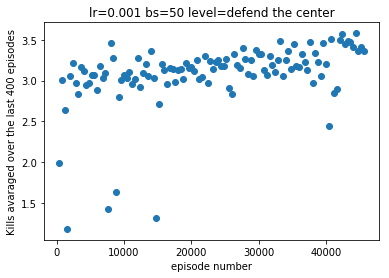

In [8]:
import matplotlib
#just to save the full list of kills if needed later
kill_list_full=kill_list

#How many episodes do we want to avg over? Note that we save values for all workers so eg.
# So if the value is 40 and we have 4 workers we get 10 values for each worker
nmb_to_avg=400
kill_list_reduced= kill_list
# Deleting the remaining kill values that are not divisible by nmb:to_avg
while (len(kill_list_reduced) % nmb_to_avg != 0):
    kill_list_reduced= kill_list_reduced[:-1]

# Plotting avg. kills as a function of episode nr. 
kill_array=np.asarray(kill_list_reduced)  
kill_avg=np.mean(kill_array.reshape(-1, nmb_to_avg), axis=1)
kill_std=np.std(kill_array.reshape(-1, nmb_to_avg), axis=1)
episode_nr=np.arange(1,len(kill_avg)+1)*nmb_to_avg
matplotlib.pyplot.scatter(episode_nr,kill_avg)
matplotlib.pyplot.xlabel("episode number")
matplotlib.pyplot.ylabel("Kills avaraged over the last " + str(nmb_to_avg) + " episodes")
matplotlib.pyplot.title("lr=" + str(lr) + " bs=" + str(batchsize) + " level=" + "defend the center" )

In [ ]:
env_cpu.close()
